In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import json
from bibliometric_sec2prim import read_config_file
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import requests
from datetime import datetime
from tqdm import tqdm
import time
import os

In [4]:
CONFIG = read_config_file('config.yml', 'hgnc')
url_genenames = 'https://rest.genenames.org/fetch/symbol/{}'
date_format = "%Y-%m-%dT%H:%M:%SZ"

# Literature usage of primary and secondary HGNC symbols

This notebook analyzes the data obtained from [`bibliometric_sec2prim.py`](bibliometric_sec2prim.py). The goal of the analyses is to get a metric of the rate of overall of _primary symbols_ (the currently approved gene symbols) as opposed to _secondary symbols_ (previous symbols no longer approved by the HGNC). The results of the analyses highlight the need to account for these _deprecated_ gene names for genes when performing data integration, especially from data sources dating from before the `sec2pri` index reached its apparent plateau after 2015.

## 1. Importing data

The data can be obtained by running thr [bibliometric sec2prim](bibliometric_sec2prim.py) Python script. This script searches and retrieves the necessary data from the Europe PMC database using its [Articles RESTful Web Service `/search` module](https://europepmc.org/RestfulWebService#!/Europe32PMC32Articles32RESTful32API/search):
```Python
base_url = "https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=ABSTRACT:\" {} \"&resultType=core&cursorMark={}&pageSize={}&format={}"
```

This allows to search for occurences of a given symbol (primary or secondary) on all available abstracts and retrieves the `journal_title`, `pubYear`,	and `pmid` for positive findings. Then, each secondary symbol result is linked back to its corresponding primary symbol.

First we import the HGNC mappings table. It consists of the following columns:
- `primaryID`: the current HGNC identifier for a gene.
- `primarySymbol`: the current HGNC symbol for a gene.
- `secondaryID`: the withdrawn HGNC identifiers for a gene.
- `secondarySymbol`: the withdrawn HGNC symbol for a gene.
- `predicateID`: the proposed mapping type between a primary and secondary symbol and ID pair.
- `source`: the source for the primary and secondary symbol and ID pair.


In [5]:
hgncs = pd.read_csv(CONFIG['hgnc']['path'], sep='\t')
print(hgncs.sample(1))

            primaryID    primarySymbol secondaryID secondarySymbol  \
4785  Entry Withdrawn  Entry Withdrawn  HGNC:42694       LINC00372   

            predicateID mapping_cardinality_sec2pri  \
4785  oboInOwl:consider                         1:0   

                                 comment  \
4785  ID (subject) withdrawn/deprecated.   

                                                 source  
4785  https://ftp.ebi.ac.uk/pub/databases/genenames/...  


Now we import the _primary symbol overall_ data obtained from `bibliometric_sec2prim.py` into a pandas DataFrame `overall_df`:

`overall_df` contains the following columns:
- `primarySymbol`, `secondarySymbol`, `mapping_cardinality_sec2pri`, etc. as defined before
- `pmid`: each distinct PubMed identifier for journal articles for which the abstract contains a hit for the symbol under `symbol`
- `symbol_code`: 0 for _primary_ and 1 for _secondary_
- `year_change`: the year the primary symbol was approved and adopted, retrieved using the `url_genenames` ('https://rest.genenames.org/fetch/symbol/{}')

In [6]:
file_path = 'overall_df.pkl'

if os.path.exists(file_path):
    overall_df = pd.read_pickle(file_path)
else:
    overall_df = generate_overall_data(hgncs, CONFIG['hgnc']['result'])
    overall_df.to_pickle(file_path)

In [7]:
print(overall_df.pmid.nunique(), 'unique publications mentioned the studied HGNC symbols in their abstracts')
overall_df.describe(include='all')

827137 unique publications mentioned the studied HGNC symbols in their abstracts


,primarySymbol,secondarySymbol,journal_title,pubYear,mapping_cardinality_sec2pri,symbol_type,pmid,year_change,symbol_code,symbol
count,1006866,1006399,1006866,1.006866e+06,1006866,1006866,1006866,133933.000000,1006866,1006866
unique,2509,2868,10657,NaN,3,2,827137,NaN,2,4562
top,SLC4A1,RH,Scientific reports,NaN,1:1,primary,22554690,NaN,0,CYP2B
freq,3059,2273,19744,NaN,731946,644429,29,NaN,644429,982
mean,NaN,NaN,NaN,2.018071e+03,NaN,NaN,NaN,2007.069662,NaN,NaN
std,NaN,NaN,NaN,7.694133e+00,NaN,NaN,NaN,4.772259,NaN,NaN
min,NaN,NaN,NaN,1.913000e+03,NaN,NaN,NaN,2001.000000,NaN,NaN
25%,NaN,NaN,NaN,2.015000e+03,NaN,NaN,NaN,2004.000000,NaN,NaN
50%,NaN,NaN,NaN,2.021000e+03,NaN,NaN,NaN,2006.000000,NaN,NaN
75%,NaN,NaN,NaN,2.024000e+03,NaN,NaN,NaN,2009.000000,NaN,NaN


In [8]:
overall_df.sample(5)

,primarySymbol,secondarySymbol,journal_title,pubYear,mapping_cardinality_sec2pri,symbol_type,pmid,year_change,symbol_code,symbol
497243,RCN1,RCN,The Journal of pathology,2014,1:1,primary,25130537,NaN,0,RCN1
79457,TAP2,ABCB3,Immunogenetics,1996,1:1,primary,8662084,NaN,0,TAP2
686648,TWNK,PEO,The journal of physical chemistry letters,2022,n:1,secondary,35130438,2016.0,1,PEO
389,PRMT5,HRMT1L5,Blood cancer journal,2023,1:1,primary,36797243,2006.0,0,PRMT5
734465,HPD,PPD,Journal of medicine and life,2024,1:1,secondary,39539432,NaN,1,PPD


However, this data set describes `primary` and `secondary` symbols in terms of the HGNC recommendations as of 2025. To determine whether a symbol found in literature was primary or secondary **at the time of publishing**, it is necessary to determine the year in which it became primary. Any `secondary` symbol found in literaure dating to before its `year_change` should be considered a `primary` symbol.

How many HGNC symbols have data for the year they were changed?

In [9]:
symbols = overall_df[['primarySymbol', 'year_change']].dropna().drop_duplicates()
total_symbols = list(set(overall_df['primarySymbol'].tolist()))
print(f'{len(symbols)} symbols out of {len(total_symbols)} with year of change field ({round(len(symbols)/len(total_symbols), 2)*100}%)')
symbols.describe()

490 symbols out of 2509 with year of change field (20.0%)


,year_change
count,490.000000
mean,2008.336735
std,4.910537
min,2001.000000
25%,2005.000000
50%,2007.000000
75%,2011.000000
max,2024.000000


In [10]:
overall_df.symbol_type.describe()

count     1006866
unique          2
top       primary
freq       644429
Name: symbol_type, dtype: object

Check for outliers

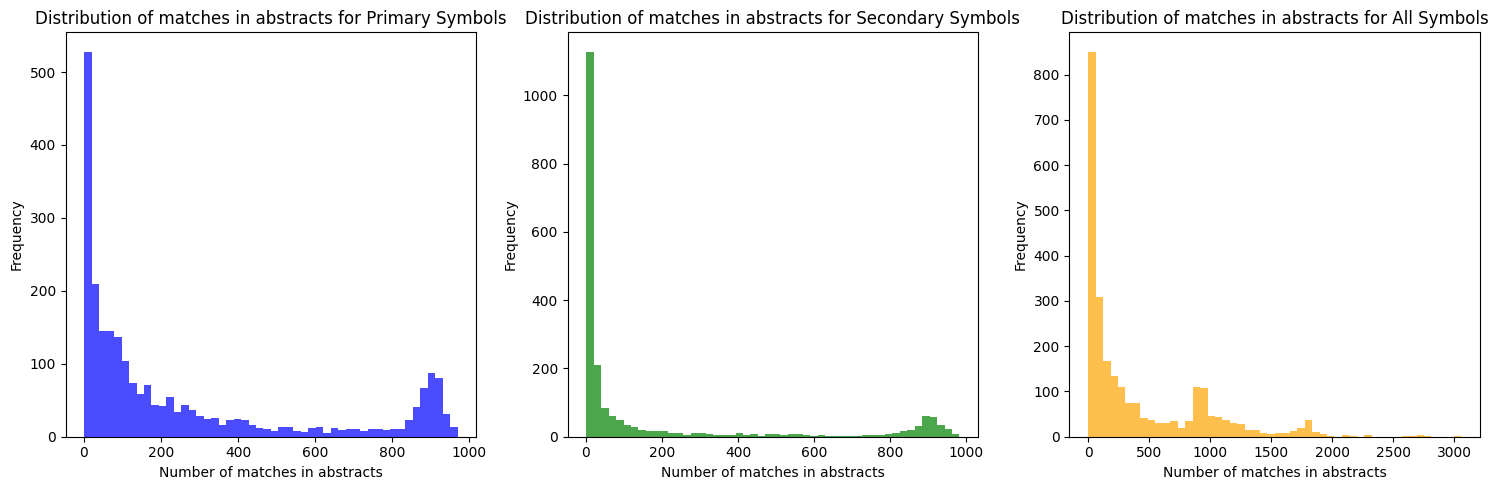

In [11]:
def plot_symbol_match_distribution(overall_df):
    # Group by primarySymbol and count matches in abstracts for each symbol
    primary_counts = overall_df[overall_df['symbol_type'] == 'primary'].groupby('primarySymbol').size()
    secondary_counts = overall_df[overall_df['symbol_type'] == 'secondary'].groupby('secondarySymbol').size()
    overall_counts = overall_df.groupby('primarySymbol').size()

    # Plot histograms
    plt.figure(figsize=(15, 5))

    # Histogram for primary symbols
    plt.subplot(1, 3, 1)
    plt.hist(primary_counts, bins=50, color='blue', alpha=0.7)
    plt.title('Distribution of matches in abstracts for Primary Symbols')
    plt.xlabel('Number of matches in abstracts')
    plt.ylabel('Frequency')

    # Histogram for secondary symbols
    plt.subplot(1, 3, 2)
    plt.hist(secondary_counts, bins=50, color='green', alpha=0.7)
    plt.title('Distribution of matches in abstracts for Secondary Symbols')
    plt.xlabel('Number of matches in abstracts')
    plt.ylabel('Frequency')

    # Histogram for all symbols
    plt.subplot(1, 3, 3)
    plt.hist(overall_counts, bins=50, color='orange', alpha=0.7)
    plt.title('Distribution of matches in abstracts for All Symbols')
    plt.xlabel('Number of matches in abstracts')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage
plot_symbol_match_distribution(overall_df)


In [12]:
def filter_symbols_by_threshold(
    df, percentile=75, use_percentile=False, min_threshold=50, max_threshold=500
):
    # Count occurrences
    primary_counts = df[df["symbol_type"] == "primary"]["primarySymbol"].value_counts()
    secondary_counts = df[df["symbol_type"] == "secondary"][
        "secondarySymbol"
    ].value_counts()
    if use_percentile:
        primary_min = primary_counts.quantile(percentile / 100)
        secondary_min = secondary_counts.quantile(percentile / 100)
    else:
        primary_min = secondary_min = min_threshold

    # No max threshold logic needed if using percentile
    valid_primary_symbols = primary_counts[primary_counts >= primary_min].index
    valid_secondary_symbols = secondary_counts[secondary_counts >= secondary_min].index

    # Filter the DataFrame
    filtered_df = df[
        (
            (df["symbol_type"] == "primary")
            & (df["primarySymbol"].isin(valid_primary_symbols))
        )
        | (
            (df["symbol_type"] == "secondary")
            & (df["secondarySymbol"].isin(valid_secondary_symbols))
        )
    ]

    return filtered_df

75th percetile of the distribution of the number of symbols per year

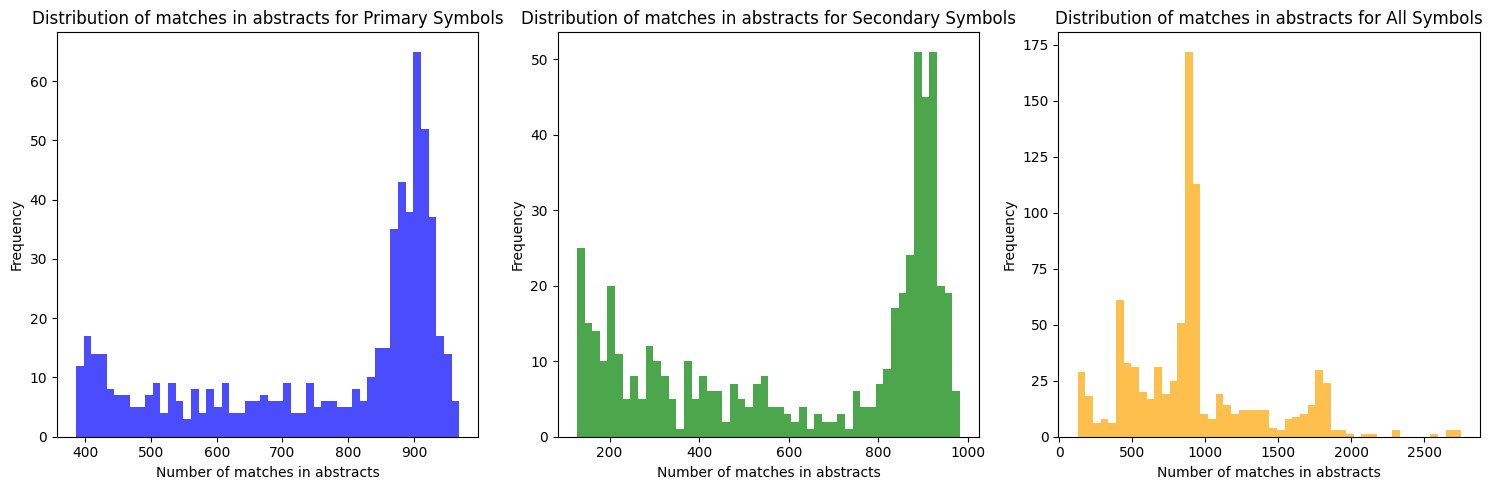

In [13]:
p75 = filter_symbols_by_threshold(
    overall_df, percentile=75, use_percentile=True
)
plot_symbol_match_distribution(p75)

50th

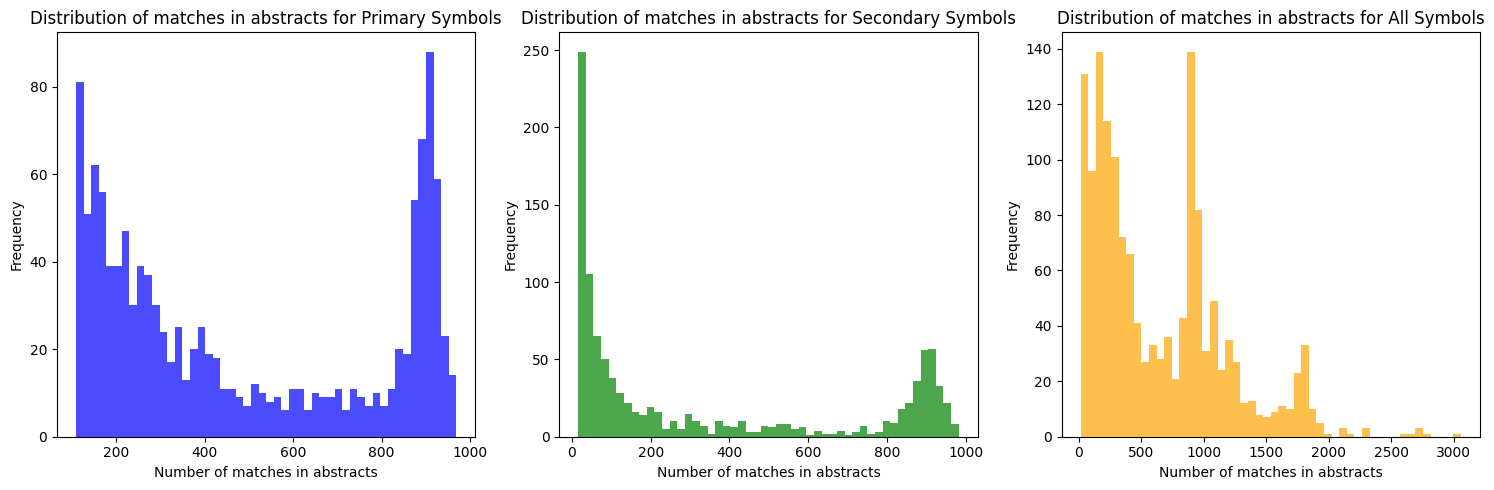

In [14]:
p50 = filter_symbols_by_threshold(
    overall_df, percentile=50, use_percentile=True
)
plot_symbol_match_distribution(p50)

## 2. Plot primary and secondary symbol usage throughout the years

### Overall
`overall_df` allows to plot the evolution of the usage of primary symbols vs secondary symbols. It is not possible to determine whether symbols were primary or secondary at the time of publishing for the cases for which cardinality is not 1 to 1, so the terms are divided into primary and secondary according to the HGNC recommendations as of 2023 and not at the time of publication for each hit.

In [15]:
overall_df = p75

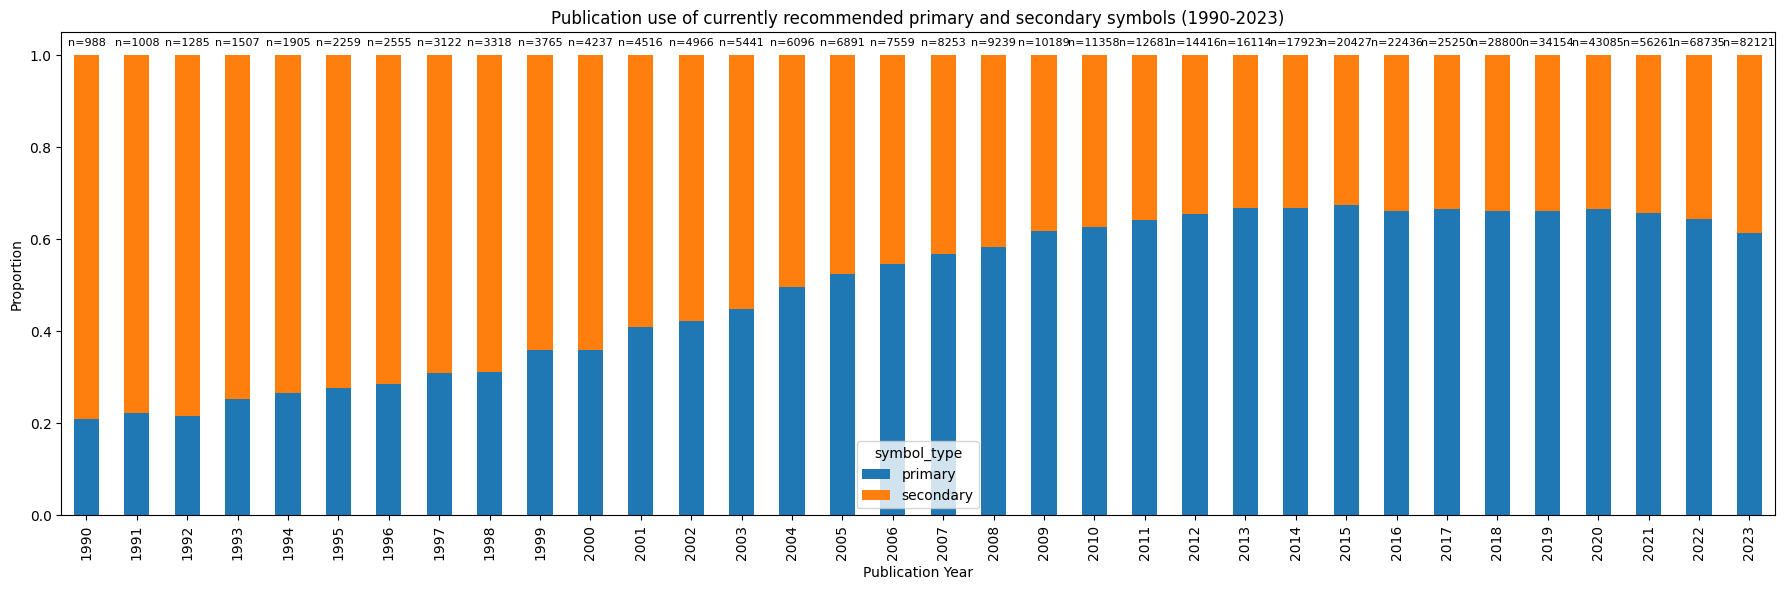

In [16]:
def plot_evolution_with_totals(overall_df, symbol_type_column, start_year=1990, end_year=2025, title="Publication use of currently recommended primary and secondary symbols"):
    # Filter and group data
    filtered_df = overall_df[(overall_df.pubYear >= start_year) & (overall_df.pubYear <= end_year)]
    grouped_df = filtered_df.groupby(["pubYear", symbol_type_column]).size().unstack()
    
    # Calculate proportions
    proportional_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)
    
    # Plot stacked bar chart
    ax = proportional_df.plot(
        kind="bar",
        stacked=True,
        figsize=(18, 6),
        title=f"{title} ({start_year}-{end_year})",
        ylabel="Proportion",
        xlabel="Publication Year"
    )
    
    # Annotate total counts on the bars
    total_counts = grouped_df.sum(axis=1)
    for i, total in enumerate(total_counts):
        ax.text(i, 1.02, f"n={int(total)}", ha="center", fontsize=8, color="black")
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_evolution_with_totals(overall_df, "symbol_type", 1990, 2023)

The primary symbol overall line shows a plateau after 2015 at around 80% of primary symbol usage versus 20% of secondary symbol usage. The issue with older publications using secondary symbols is apparent. 

However, this plot does not account for the facts that:
- some secondary symbols were actually primary at the time of publication, and
- for cardinalities that are not 1 to 1, it is not possible to determine whether the symbol was primary or secondary at the time of publication.

The rate of overall primary symbol seems to have hit a plateau at around 80%.

## Subset for adoption after change for 1-to-1 cardinality symbols

This section analyzes the subset of symbols with a 1-to-1 cardinality mapping between primary and secondary symbols. This means that for each secondary symbol, there is only one primary symbol that it maps to, and vice versa. This allows to determine whether a symbol was primary or secondary at the time of publishing.

In [45]:
def subset_at_moment_of_publishing(overall_df, symbol_type):
    original_length = len(overall_df)
    min_year = overall_df["year_change"].min()
    overall_df = overall_df[(overall_df["year_change"] >= min_year)]
    other = "primary" if symbol_type == "secondary" else "secondary"
    subset_df = overall_df[
        (overall_df["mapping_cardinality_sec2pri"] == "1:1")
        & (overall_df["symbol_type"] == symbol_type)
    ].dropna(subset=["year_change"])

    # Fixed logic for category assignment
    if symbol_type == "primary":
        subset_df["category"] = subset_df.apply(
            lambda row: (
                f"usage: primary"
                if row["pubYear"] >= row["year_change"]
                else f"usage: secondary"
            ),
            axis=1,
        )
    else:  # symbol_type == "secondary"
        subset_df["category"] = subset_df.apply(
            lambda row: (
                f"usage: secondary"
                if row["pubYear"] < row["year_change"]
                else f"usage: primary"
            ),
            axis=1,
        )

    new_length = len(subset_df)
    change_sym = len(subset_df[subset_df["category"] == f"usage: {symbol_type}"])
    change_other = len(subset_df[subset_df["category"] == f"usage: {other}"])
    total = len(subset_df)

    print(
        f"{change_sym} out of {total} ({change_sym / total * 100:.2f}%) publication hits \nwhere the matched HGNC symbol used is currently a\n{symbol_type} symbol have been annotated as\nactually containing a {symbol_type} symbol at the time of publishing. \nOn the other hand, {change_other} ({change_other / total * 100:.2f}%) were actually {other} at the moment of publishing.\n.\nDropped {original_length - new_length} rows from the {symbol_type} subset ({new_length*100/original_length:.2f}%) that did not have a known year_change.\n\n",
    )
    return subset_df

In [46]:
primary_atm = subset_at_moment_of_publishing(overall_df, "primary")
secondary_atm = subset_at_moment_of_publishing(overall_df, "secondary")

47272 out of 49926 (94.68%) publication hits 
where the matched HGNC symbol used is currently a
primary symbol have been annotated as
actually containing a primary symbol at the time of publishing. 
On the other hand, 2654 (5.32%) were actually secondary at the moment of publishing.
.
Dropped 28705 rows from the primary subset (63.49%) that did not have a known year_change.


4434 out of 28705 (15.45%) publication hits 
where the matched HGNC symbol used is currently a
secondary symbol have been annotated as
actually containing a secondary symbol at the time of publishing. 
On the other hand, 24271 (84.55%) were actually primary at the moment of publishing.
.
Dropped 49926 rows from the secondary subset (36.51%) that did not have a known year_change.




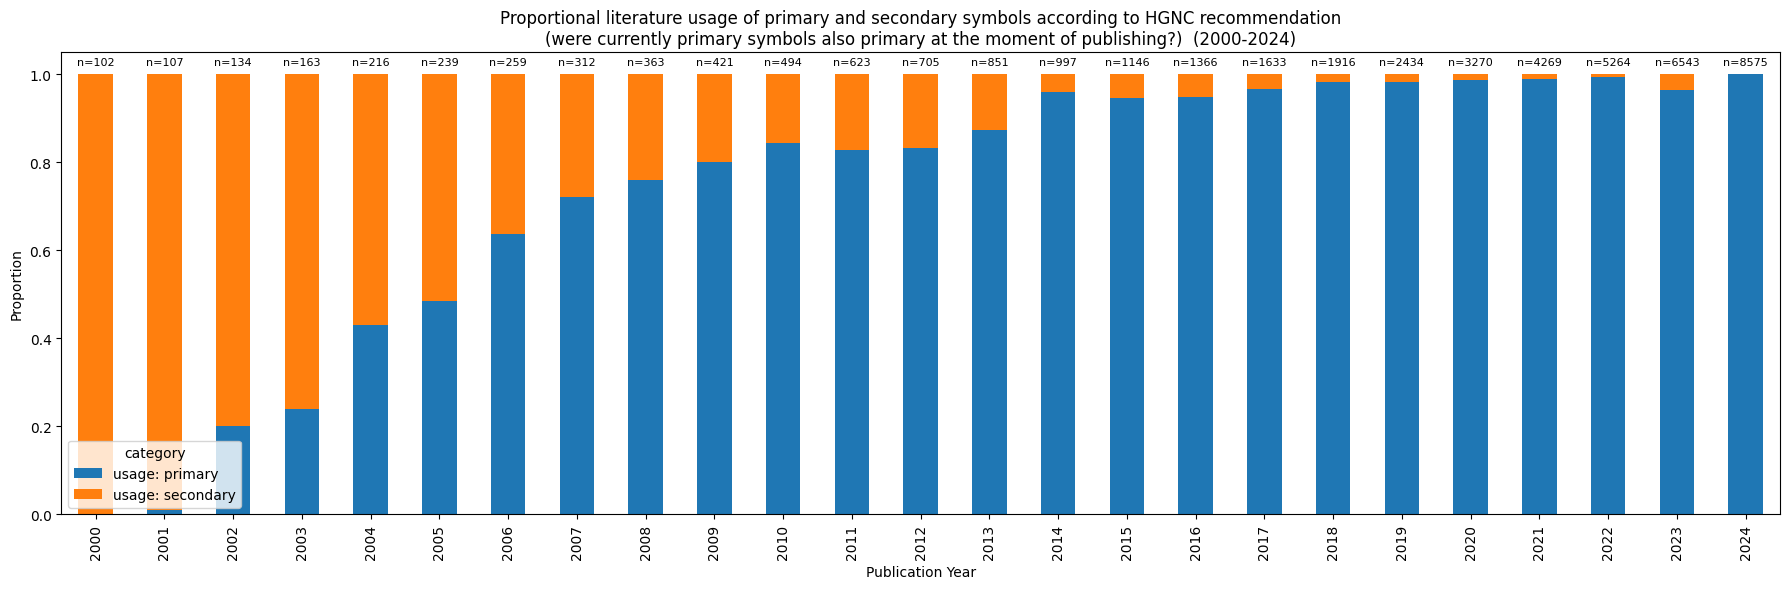

In [47]:
plot_evolution_with_totals(primary_atm, 
               "category", 
               start_year=2000, 
               end_year=2024, 
               title= "Proportional literature usage of primary and secondary symbols according to HGNC recommendation\n(were currently primary symbols also primary at the moment of publishing?) ",)

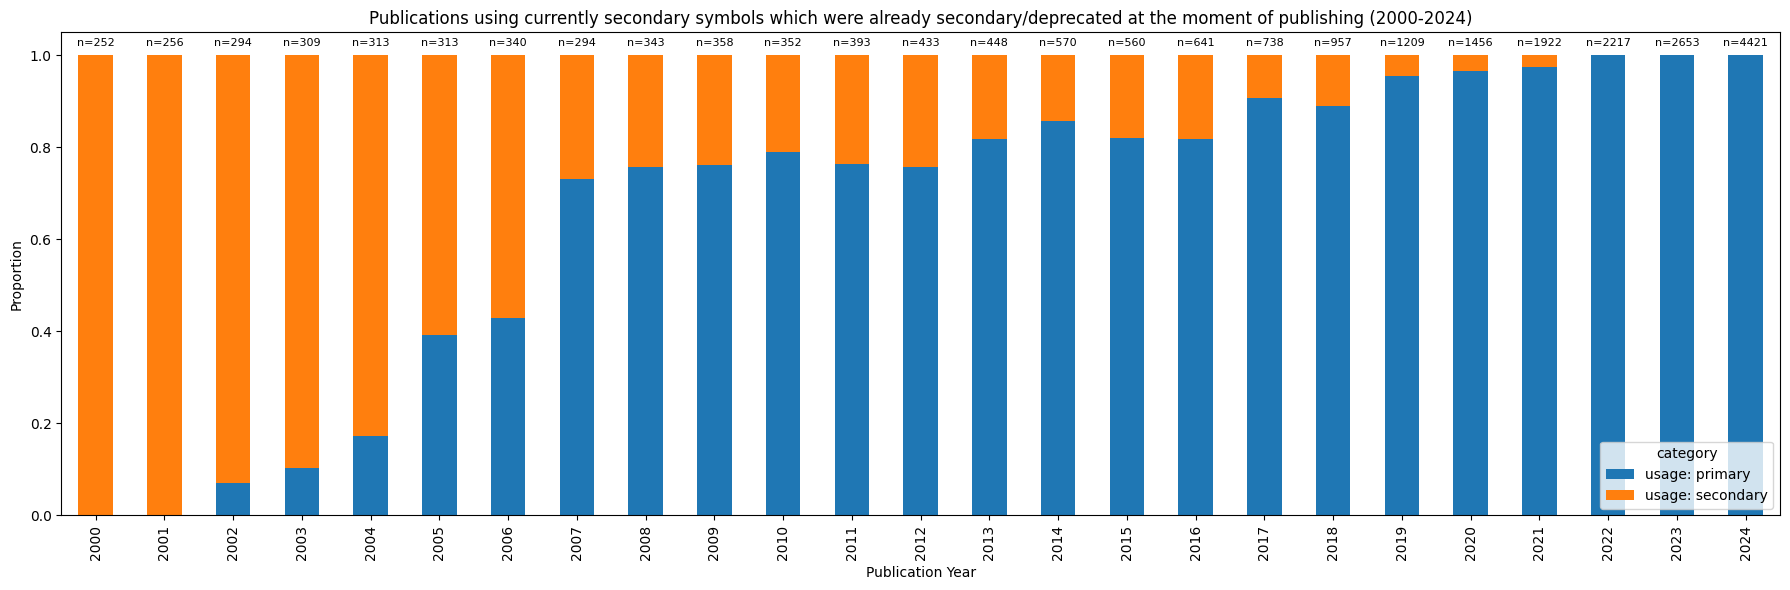

In [48]:
plot_evolution_with_totals(
    secondary_atm,
    "category",
    start_year=2000,
    end_year=2024,
    title="Publications using currently secondary symbols which were already secondary/deprecated at the moment of publishing",
)

In [38]:
overall_df = pd.concat([primary_atm, secondary_atm], ignore_index=True)
overall_df.describe(include='all')

,primarySymbol,secondarySymbol,journal_title,pubYear,mapping_cardinality_sec2pri,symbol_type,pmid,year_change,symbol_code,symbol,category
count,78631,78631,78631,78631.000000,78631,78631,78631,78631.000000,78631,78631,78631
unique,92,92,6037,NaN,1,2,75840,NaN,2,112,2
top,CXCL9,CMK,Scientific reports,NaN,1:1,primary,39267759,NaN,0,LHON,usage: primary
freq,1811,1811,1725,NaN,78631,49926,5,NaN,49926,964,51706
mean,NaN,NaN,NaN,2019.375870,NaN,NaN,NaN,2007.400694,NaN,NaN,NaN
std,NaN,NaN,NaN,6.824385,NaN,NaN,NaN,5.319845,NaN,NaN,NaN
min,NaN,NaN,NaN,1974.000000,NaN,NaN,NaN,2001.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,2018.000000,NaN,NaN,NaN,2004.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,2022.000000,NaN,NaN,NaN,2006.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,2024.000000,NaN,NaN,NaN,2009.000000,NaN,NaN,NaN


## Further questions:
- Which are the best regarded journals in terms of HGNC usage?
- Some journals have guidance on symbol usage - does it have an effect?

## 2. Sec2Pri index

We calculate the sec2pri index for each gene, year and journal. The sec2pri index is defined as follows, with 
- p = number of instances of a publication containing a primary symbol in its abstract, and 
- s = number of publications using any of the secondary symbols associated to p in its abstract:

$$ sec2pri = {\sum s \over \sum s + p} $$

In [39]:
def sec2pri(df, aggregate_journal = True):
    primary_df = df[df['symbol_type'] == 'primary']
    secondary_df = df[df['symbol_type'] == 'secondary']
    grouped_primary = primary_df.groupby(['journal_title', 'pubYear', 'primarySymbol']).agg({'pmid': 'nunique'}).reset_index()
    grouped_secondary = secondary_df.groupby(['journal_title', 'pubYear', 'secondarySymbol', 'primarySymbol']).agg({'pmid': 'nunique'}).reset_index()
    merged = grouped_primary.merge(grouped_secondary, on=['journal_title', 'pubYear', 'primarySymbol'], how='left')
    merged.rename(columns={'pmid_x': 'pmid_primary', 'pmid_y': 'pmid_secondary'}, inplace=True)
    merged['pmid_secondary'] = merged['pmid_secondary'].fillna(0)
    merged['sec2pri'] = merged['pmid_secondary']/(merged['pmid_secondary']+merged['pmid_primary'])
    
    merged = merged.drop(['secondarySymbol'], axis=1).drop_duplicates()
    if aggregate_journal:
        merged = merged.groupby(['journal_title', 'pubYear']).agg(
            sec2pri_mean=('sec2pri', 'mean'),
            #sec2pri_var=('sec2pri', 'var')
).reset_index()
    #else:
        #merged['sec2pri_var'] = merged.groupby('primarySymbol')['sec2pri'].transform('var')
    return merged

In [40]:
sec2pri_all = sec2pri(overall_df, False)
sec2pri_all.sample(3)

,journal_title,pubYear,primarySymbol,pmid_primary,pmid_secondary,sec2pri
28736,Nature genetics,2012,GREM1,1,0.0,0.0
1078,American journal of cancer research,2023,IGH,1,0.0,0.0
21534,Journal of cellular and molecular medicine,2018,FOXO3,1,0.0,0.0


In [41]:
sec2pri_all.describe()

,pubYear,pmid_primary,pmid_secondary,sec2pri
count,39022.000000,39022.000000,39022.000000,39022.000000
mean,2019.875788,1.279432,0.035647,0.011752
std,5.629026,1.029075,0.297922,0.077002
min,1975.000000,1.000000,0.000000,0.000000
25%,2018.000000,1.000000,0.000000,0.000000
50%,2022.000000,1.000000,0.000000,0.000000
75%,2024.000000,1.000000,0.000000,0.000000
max,2026.000000,65.000000,23.000000,0.958333


### 2.1.    Mean sec2pri value for journal and year

The sec2pri values are summarized by journal and year of publishing with the `pivot_table` method and visualized in a color map.

- **Journals with most gene symbol hits**

First we retrieve the top 10 journals in terms of bibliometric hits for either primary or secondary symbols.

In [42]:
top_10 = overall_df['journal_title'].value_counts().head(10).index.tolist()
print("-", "\n- ".join(top_10))

- Scientific reports
- International journal of molecular sciences
- PloS one
- Frontiers in immunology
- The Journal of biological chemistry
- Nature communications
- Proceedings of the National Academy of Sciences of the United States of America
- Cancers
- Frontiers in oncology
- Biochemical and biophysical research communications


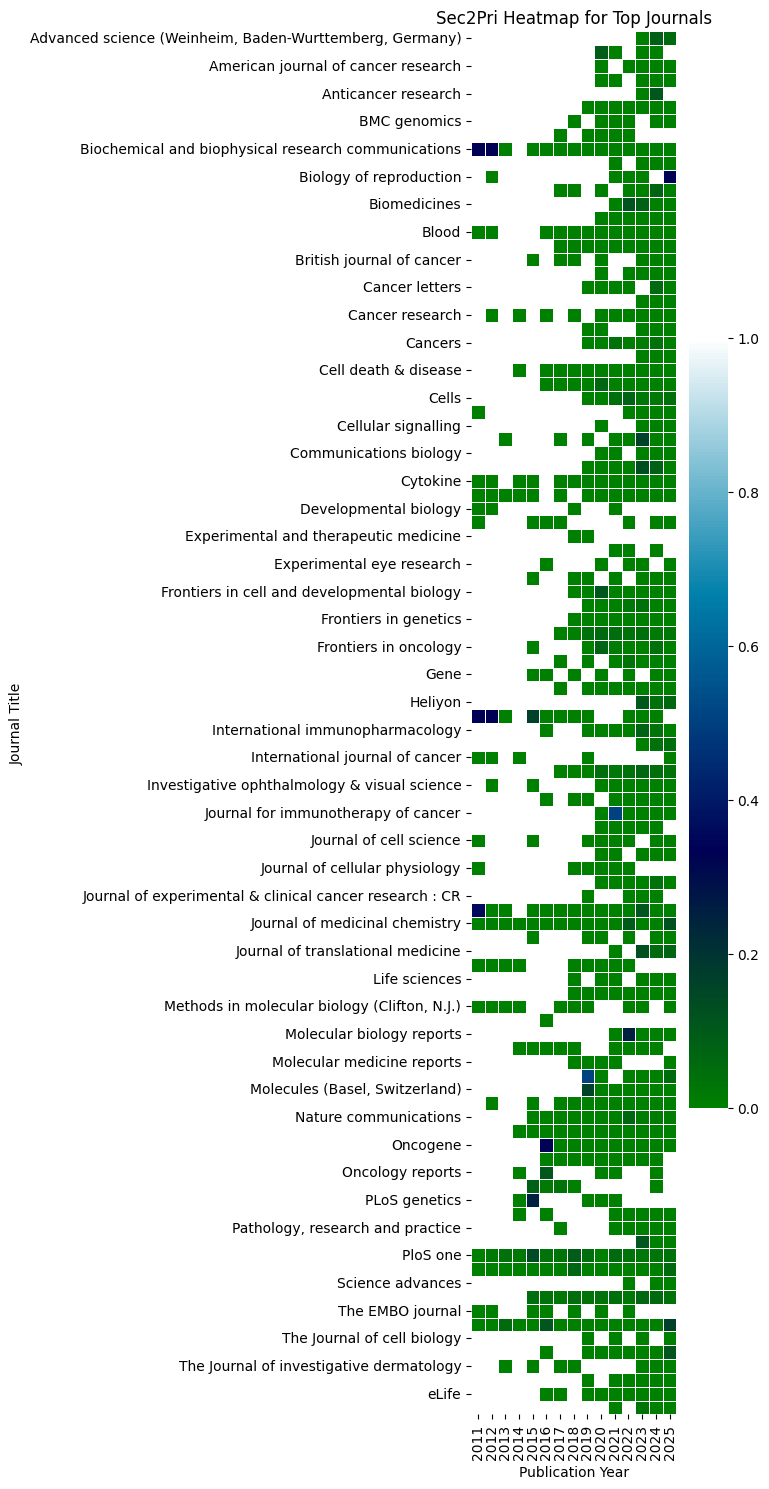

In [43]:
def plot_sec2pri_heatmap(data, subset_threshold=None, year_threshold=2010, min_primary_hits=1, cmap='ocean', vmin=0, vmax=1):
    if subset_threshold is not None:
        subset_journals = (
            data["journal_title"].value_counts().head(subset_threshold).index.tolist()
        )
    else:
        subset_journals = data["journal_title"].unique().tolist()
    filtered_data = (
        data[(data['pubYear'] > year_threshold) & (data['pmid_primary'] > min_primary_hits)]
        .loc[data['journal_title'].isin(subset_journals)]
    )
    pivot_table = filtered_data.pivot_table(index='journal_title', columns='pubYear', values='sec2pri')

    # Adjust figure size based on the number of rows and columns
    num_rows, num_cols = pivot_table.shape
    plt.figure(figsize=(min(40, num_cols * 0.5), min(15, num_rows * 0.5)))

    sns.heatmap(pivot_table, cmap=cmap, vmin=vmin, vmax=vmax, annot=False, linewidths=0.5)
    plt.title("Sec2Pri Heatmap for Top Journals")
    plt.xlabel("Publication Year")
    plt.ylabel("Journal Title")
    plt.tight_layout()
    plt.show()

plot_sec2pri_heatmap(sec2pri_all, subset_threshold=100)

In [44]:
table.sample(3)

NameError: name 'table' is not defined

### 2.3. Mean sec2pri value for gene and year



- Most variable genes

We find the genes for which the `sec2pri` index seems to be the most variable by retrieving the unbiased variance over the `sec2pri` column for each distinct `primarySymbol`:

In [ ]:
sec2pri_all['sec2pri_var'] = sec2pri_all.groupby('primarySymbol')['sec2pri'].transform('var')
sec2pri_all['sec2pri_var'].describe()

count    372859.000000
mean          0.007250
std           0.014086
min           0.000000
25%           0.000000
50%           0.000000
75%           0.007822
max           0.077750
Name: sec2pri_var, dtype: float64

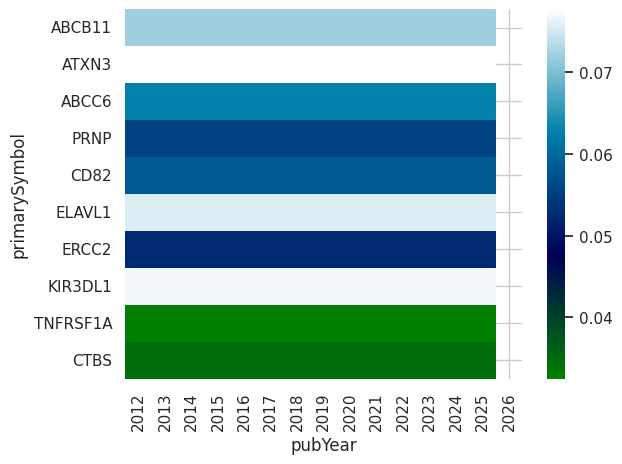

In [ ]:
table = sec2pri_all[sec2pri_all['pubYear']>2011].pivot_table(index='primarySymbol', columns='pubYear', values='sec2pri_var')

# Sort the genes by their variance and select the top 100
top_10_genes = table.var(axis=1).sort_values(ascending=False).head(10).index
table_top_10 = table.loc[top_10_genes]

# Create the heatmap using seaborn
sns.heatmap(table_top_10, cmap='ocean')

# Show the plot
plt.show()

## 4. Considering year of approval of the HGNC symbol
We continue the analyses on a subset of symbols for which the year of change (the year the current primary symbol was approved) could be retrieved.

In [ ]:
overall_df['year_change'] = pd.to_numeric(overall_df['year_change'], errors='coerce')
subset_df = overall_df.dropna(subset=['year_change'])
subset_df.describe()

,pubYear,year_change
count,103196.000000,103196.000000
mean,2019.725619,2007.093821
std,6.806090,4.894962
min,1973.000000,2001.000000
25%,2018.000000,2004.000000
50%,2022.000000,2006.000000
75%,2024.000000,2009.000000
max,2026.000000,2024.000000


The first symbol changes took place in 2001. The mean year of change is 2006.9 ± 4.1.
- 2006

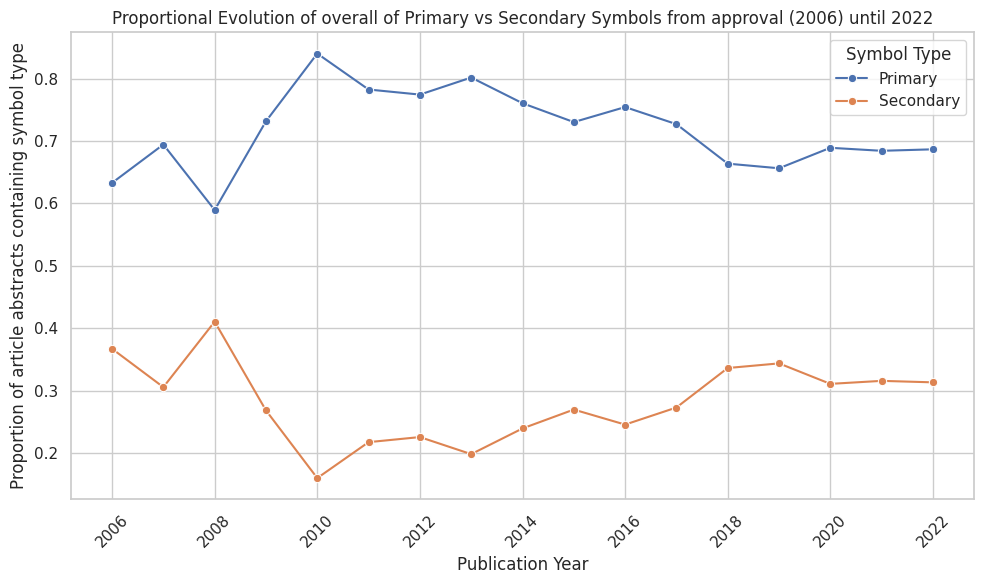

In [ ]:
plot_overall_evolution(subset_df[subset_df['year_change'] == 2006], (2006,2022), title='Proportional Evolution of overall of Primary vs Secondary Symbols from approval ({}) until {}')

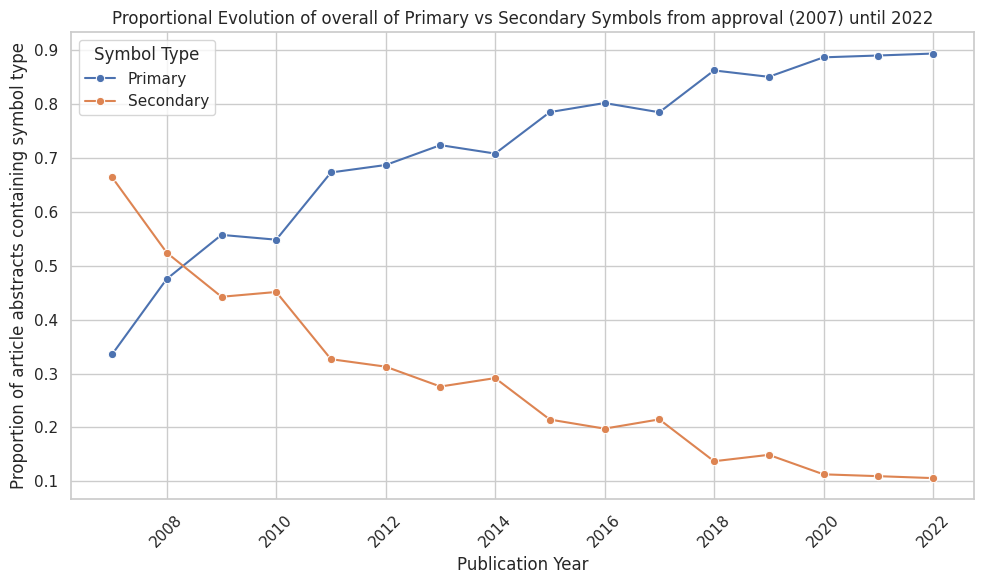

In [ ]:
plot_overall_evolution(subset_df[subset_df['year_change'] == 2007], (2007,2022), title='Proportional Evolution of overall of Primary vs Secondary Symbols from approval ({}) until {}')

In [ ]:
def plot_primary_evolution(overall_df, year_range=(2000, 2022), title='Proportional Evolution of overall of Primary Symbols ({0}-{1})', year_subset=None):
    try:
        # Filter by year range
        overall_df = overall_df[(overall_df['pubYear'] >= year_range[0]) & (overall_df['pubYear'] <= year_range[1])]

        # Create a count plot
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")

        # Extract unique 'year_change' values
        unique_year_changes = overall_df['year_change'].unique()

        if year_subset is not None:
            if isinstance(year_subset, range):
                year_subset = list(year_subset)
            # Filter by the specified year subset
            unique_year_changes = [year_change for year_change in unique_year_changes if year_change in year_subset]

        for year_change_value in unique_year_changes:
            subset_df = overall_df[overall_df['year_change'] == year_change_value]

            # Count the number of primary symbols for each year in the subset
            primary_counts = subset_df[subset_df['symbol_type'] == 'primary'].groupby('pubYear').size()
            secondary_counts = subset_df[subset_df['symbol_type'] == 'secondary'].groupby('pubYear').size()

            # Calculate the proportion of primary symbols
            primary_normalized = primary_counts / (primary_counts + secondary_counts)

            # Plot the line for normalized primary symbols
            sns.lineplot(x=primary_normalized.index, y=primary_normalized.values, label=f'Year Change: {year_change_value}')

            # Add a vertical line at the 'year_change'
            plt.axvline(x=year_change_value, color='gray', linestyle='--', linewidth=1, label=f'Year Change: {year_change_value}')

        plt.xlabel('Publication Year')
        plt.ylabel('Proportion of article abstracts containing primary symbols')
        plt.title(title.format(year_range[0], year_range[1]))
        plt.legend(title='Year Change', bbox_to_anchor=(1, 1), loc='upper left')  # Move the legend outside the plot
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

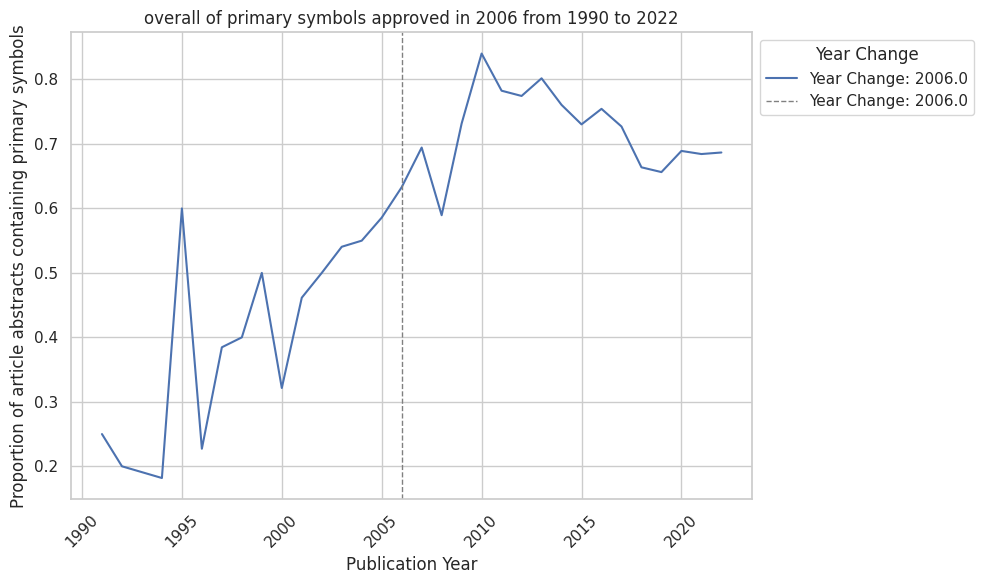

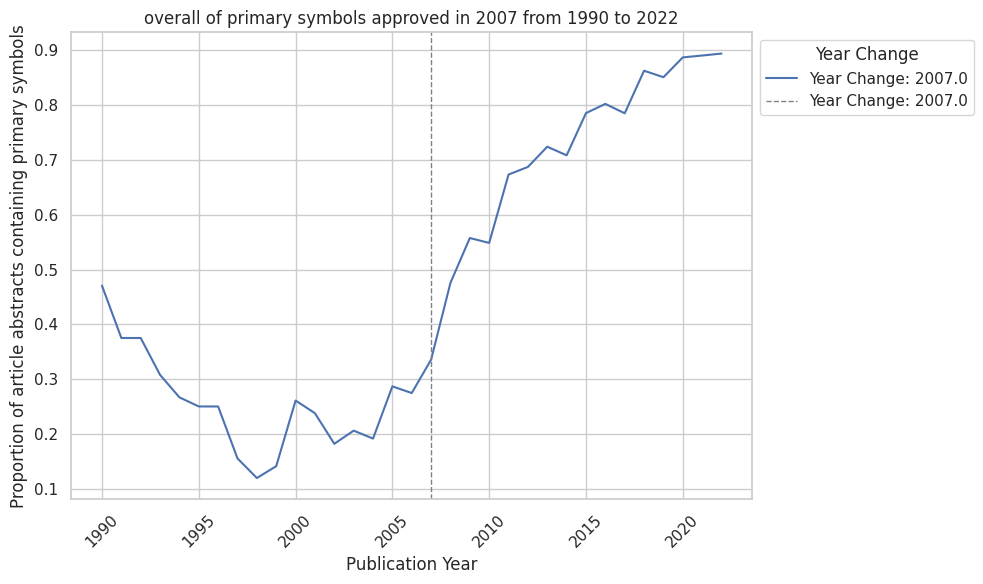

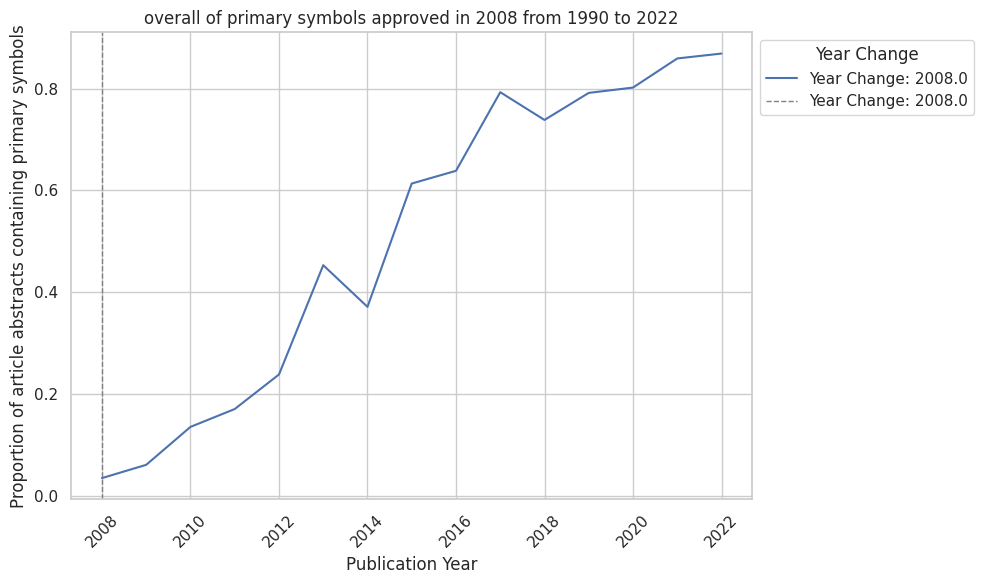

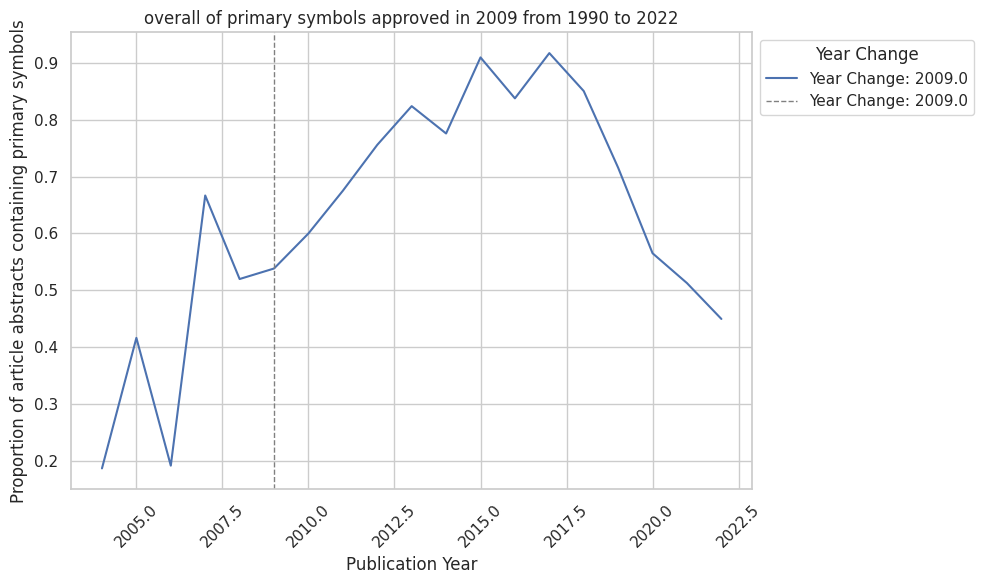

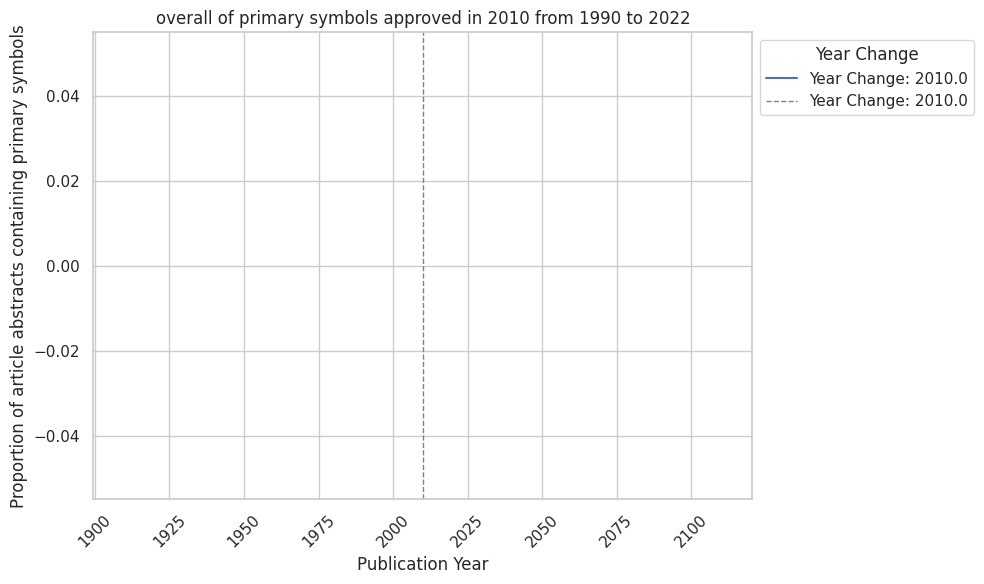

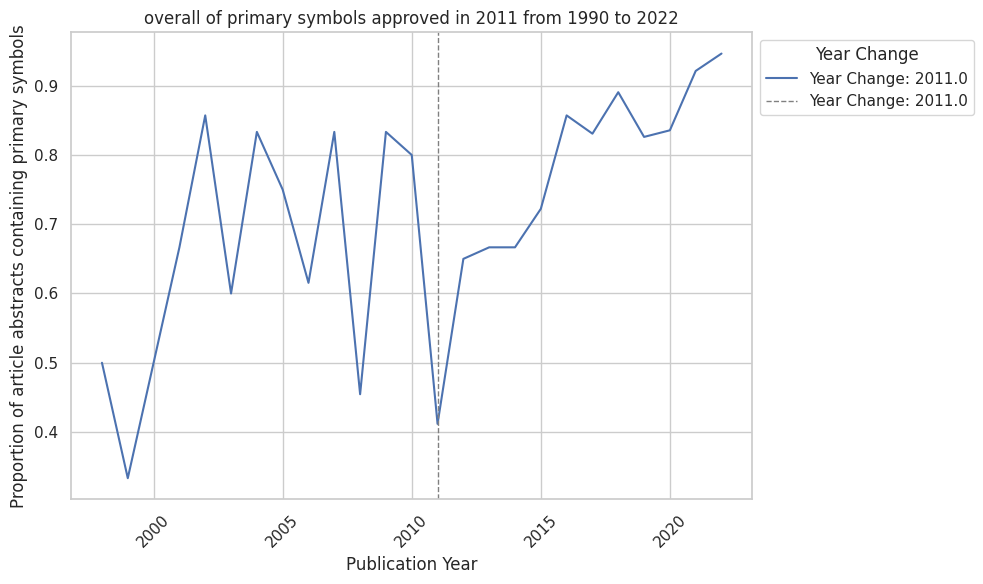

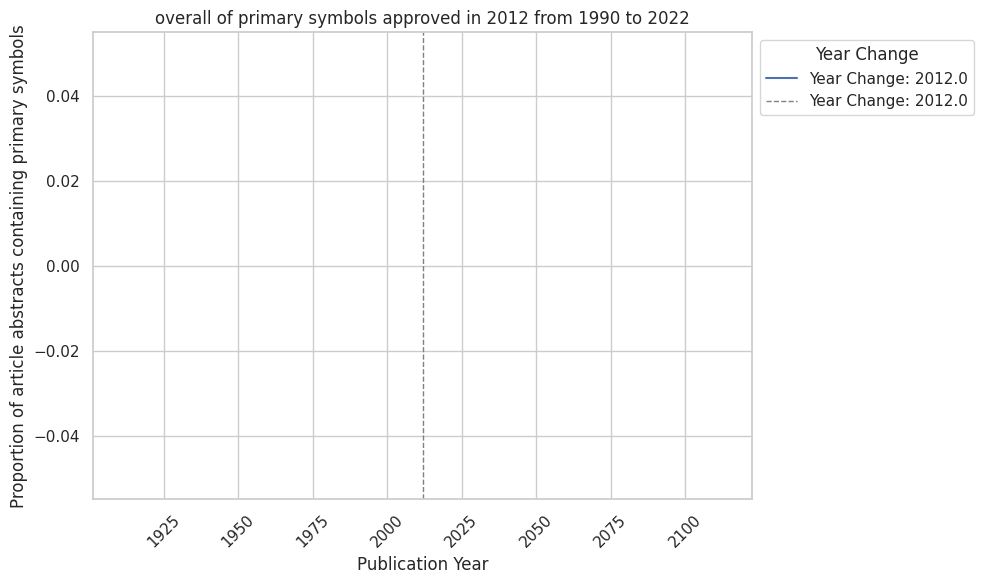

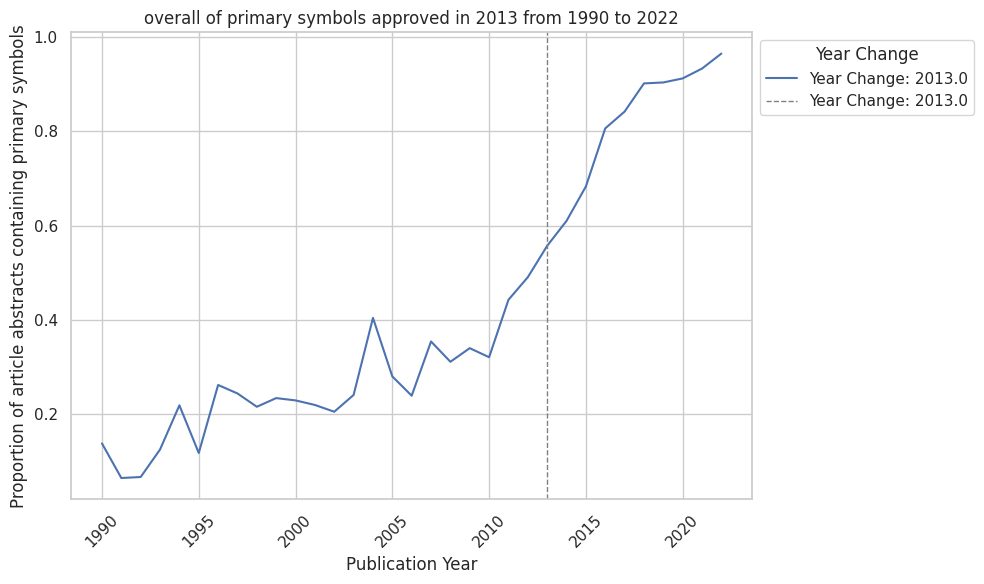

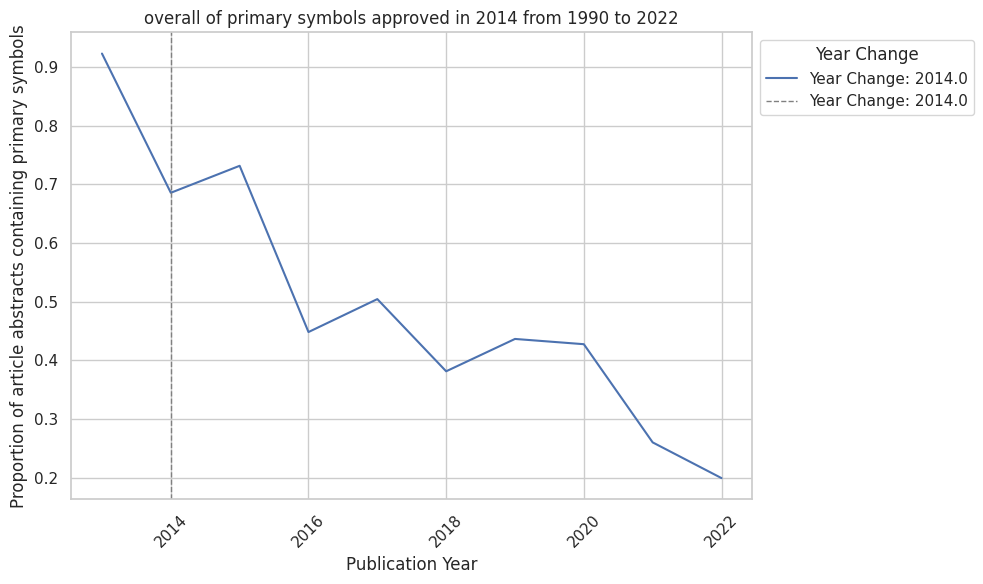

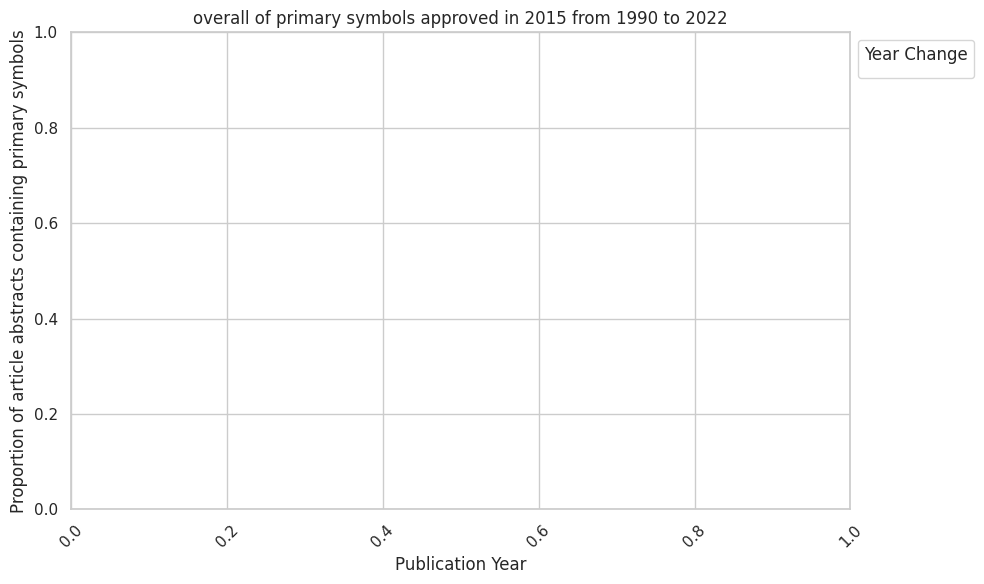

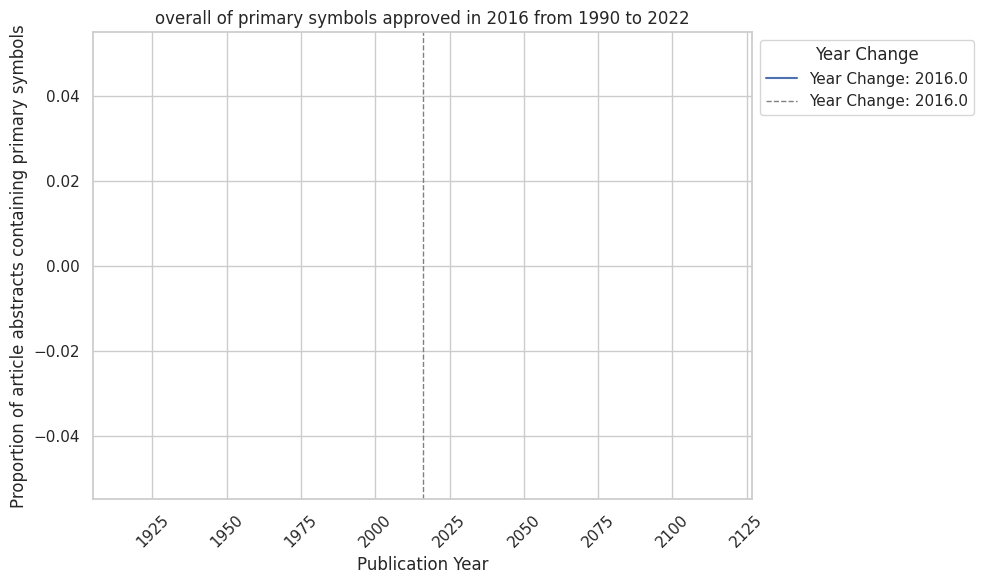

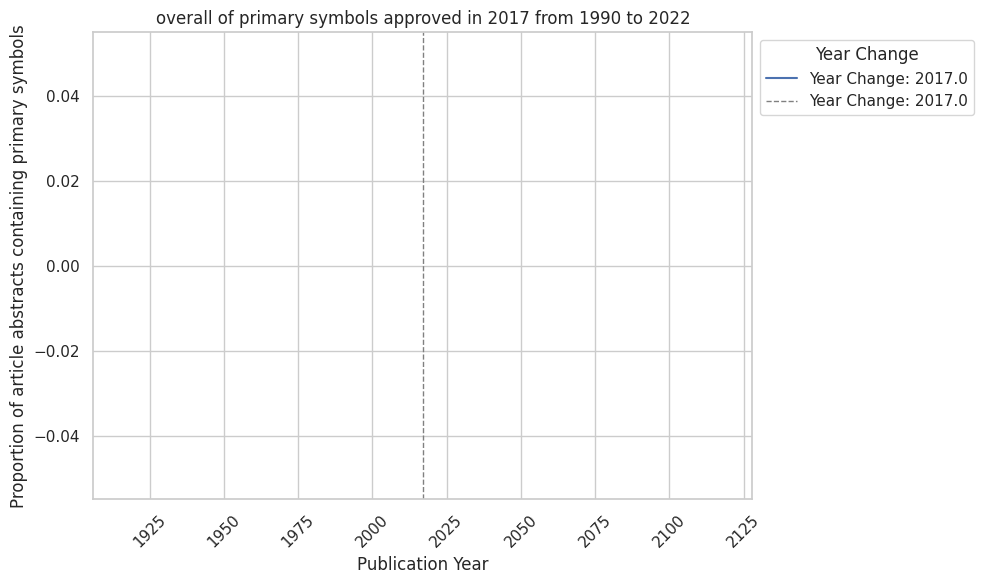

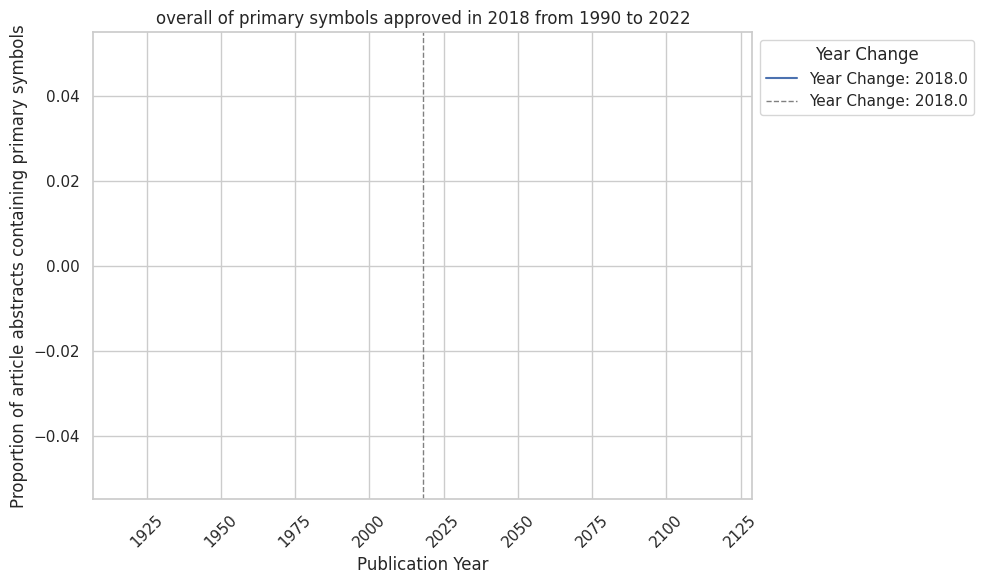

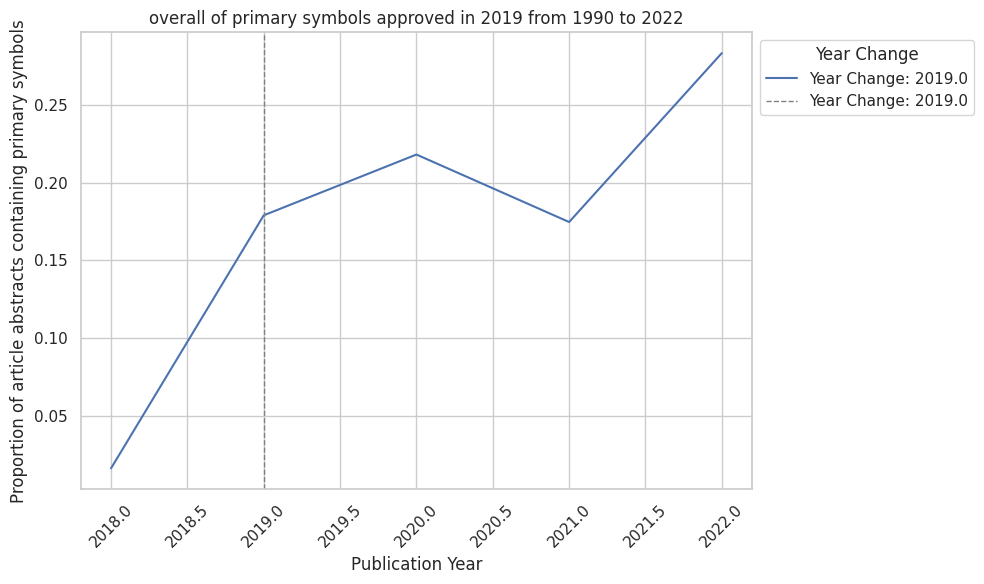

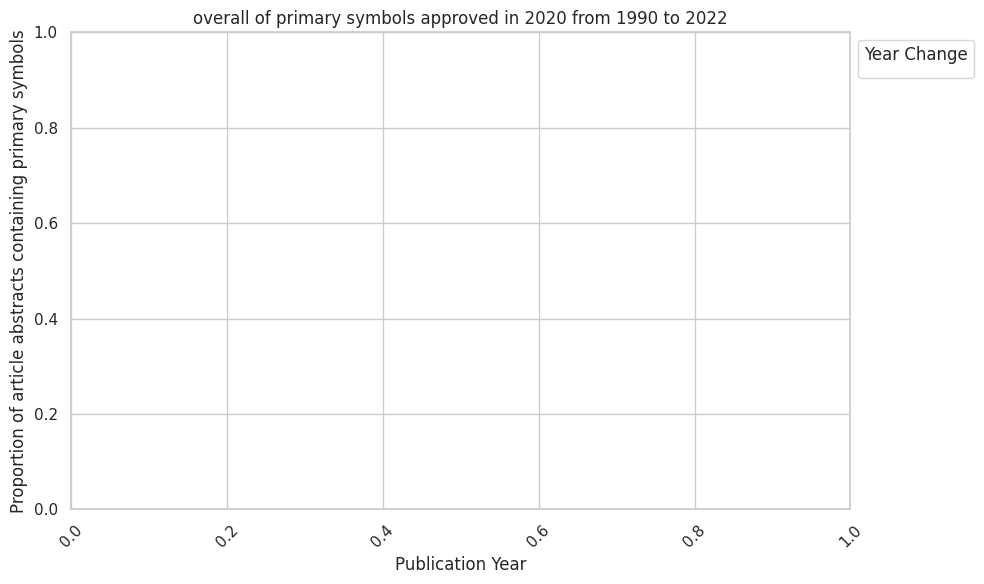

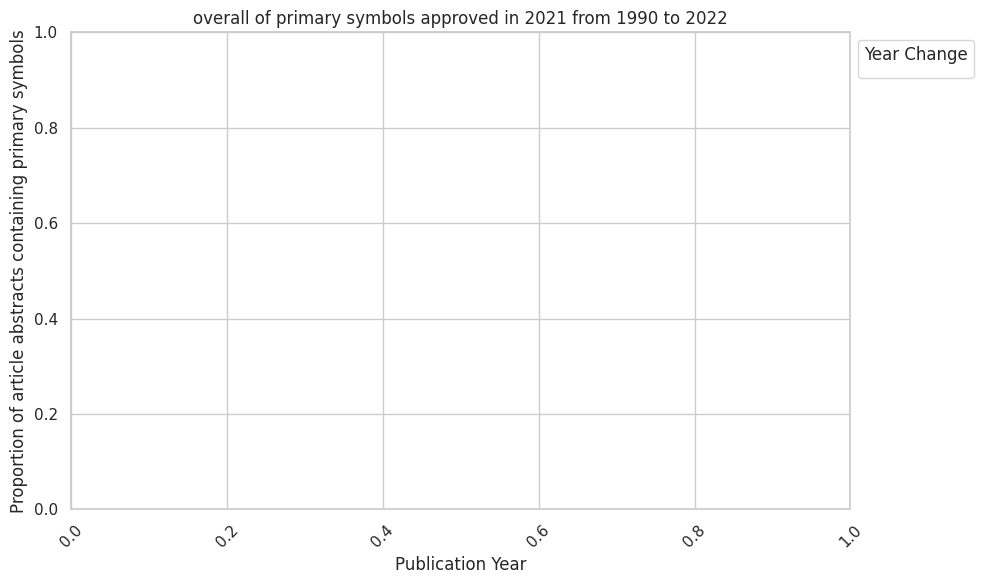

In [ ]:
for year in range(2006, 2022):
    plot_primary_evolution(overall_df, (1990, 2022), year_subset=[year], title = f'overall of primary symbols approved in {year} ' + 'from {} to {}')

### overall after approval index
We can define an `overall after approval` index by the formula:

$$ overall_{after} = {a \over b} $$

with:
- `a` = the proportional usage of primaries afer the `year_change`
- `b` = the proportional usage of primaries before the `year_change`

In [ ]:
def calculate_adoption_after_approval(overall_df):
    try:
        # Ensure 'pubYear' and 'year_change' are numeric
        overall_df['pubYear'] = pd.to_numeric(overall_df['pubYear'], errors='coerce')
        overall_df['year_change'] = pd.to_numeric(overall_df['year_change'], errors='coerce')

        # Filter out rows with missing or invalid values in 'pubYear' and 'year_change'
        overall_df = overall_df.dropna(subset=['pubYear', 'year_change'])

        # Calculate proportional usage of primaries after year_change
        after_approval = overall_df[overall_df['pubYear'] > overall_df['year_change']]
        primary_counts_after = after_approval[after_approval['symbol_type'] == 'primary'].groupby('pubYear').size()
        primary_normalized_after = primary_counts_after / primary_counts_after.sum()

        # Calculate proportional usage of primaries before year_change
        before_approval = overall_df[overall_df['pubYear'] <= overall_df['year_change']]
        primary_counts_before = before_approval[before_approval['symbol_type'] == 'primary'].groupby('pubYear').size()
        primary_normalized_before = primary_counts_before / primary_counts_before.sum()

        # Merge the two datasets to calculate the adpotion_after_approval index
        overall_df = pd.merge(overall_df, pd.DataFrame(primary_normalized_after, columns=['primary_after']), how='left', left_on='pubYear', right_index=True)
        overall_df = pd.merge(overall_df, pd.DataFrame(primary_normalized_before, columns=['primary_before']), how='left', left_on='pubYear', right_index=True)
        overall_df['adoption_after_approval_index'] = overall_df['primary_after'] / overall_df['primary_before']

        return overall_df

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
subset_df_aaa = calculate_adoption_after_approval(subset_df)


In [ ]:
subset_df_aaa.describe()

,pubYear,year_change,primary_after,primary_before,adoption_after_approval_index
count,103196.000000,103196.000000,99221.000000,83168.000000,79196.000000
mean,2019.725619,2007.093821,0.111123,0.042199,2.739845
std,6.806090,4.894962,0.065729,0.030347,1.862878
min,1973.000000,2001.000000,0.000034,0.000543,0.009420
25%,2018.000000,2004.000000,0.047342,0.016011,2.019034
50%,2022.000000,2006.000000,0.131025,0.024152,2.090155
75%,2024.000000,2009.000000,0.179138,0.062687,4.556506
max,2026.000000,2024.000000,0.183549,0.090909,6.618797


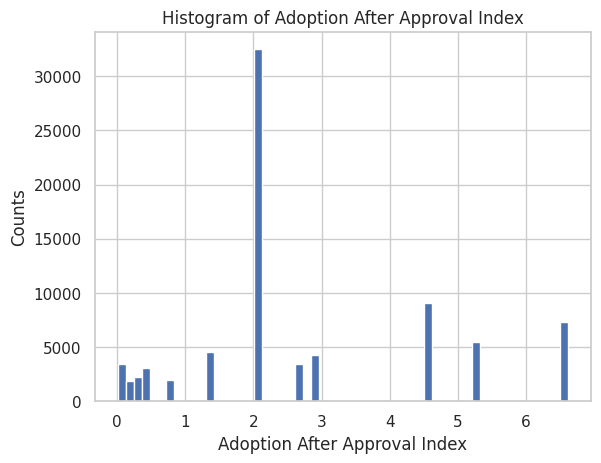

In [ ]:
plt.hist(subset_df_aaa['adoption_after_approval_index'], bins='auto')
plt.xticks(range(int(subset_df_aaa['adoption_after_approval_index'].min()), int(subset_df_aaa['adoption_after_approval_index'].max()) + 1))

plt.xlabel('Adoption After Approval Index')
plt.ylabel('Counts')
plt.title('Histogram of Adoption After Approval Index')

plt.show()

In [ ]:
worst_aaa = set(subset_df_aaa[subset_df_aaa['adoption_after_approval_index']<1].primarySymbol)
print(f'{len(worst_aaa)} symbols have a `aaa`<1, indicating an incomplete adoption of the primary symbol')

79 symbols have a `aaa`<1, indicating an incomplete adoption of the primary symbol


In [ ]:
print("\n".join(worst_aaa))

EIF1AX
CADM1
GREM1
PRMT5
MT-TK
RAD51D
ELP1
FOXO3
SCN2A
MED12
FOXG1
RBPJ
SCX
CXCL1
CCN1
PTCH1
STX2
UGT8
CD82
CFB
AGO2
ACAN
TRA
FOXN1
STMN1
AGT
FAS
HSP90AA1
CTAG1B
HNF1A
NLRP1
ATXN3
IL17A
HNRNPD
EIF3A
TRG
CXCL11
ALDH18A1
ZC4H2
OLIG2
CD46
EDA
TRB
ZP3
CXCR1
UBA1
RHOB
SERPINA2
RNF213
CXCL9
XIAP
GBA1
KLF6
XK
CDC45
KMT2D
TPX2
S1PR2
NKX2-1
TPSAB1
MORF4
TRD
CTSA
PIEZO2
WNK1
ATXN2
CRYBG1
MECOM
CFH
HDAC8
FOXO1
SDHAF2
TYMP
TPP1
CD70
CCL4
GPER1
LYST
MT-ND4


## 5. Discussion
### Limitations
- All data were retrieved and generated programatically and there were no manual checks to determine whether a _hit_ for a gene symbol in literature actually corresponds to a gene symbol and not a homograph.It is assumed that all text hits correspond to mentions of gene symbols.
- The `cardinality_1to1` data set is the only one that helps understand the rate of adoption of primary symbols, as it contains for all of its entries both the `year_change` (the year in which the primary symbol became primary) and a one-to-one relationship between primary and secondary identifiers.

### Impact
- The rate at which secondary identifiers are still found in literature published in 2023 (at around 20%) is enough to justify the utility of the `omics fixID` tool.
- Moreover, this rate is consistently lower for older publications dropping at around 50% and below for 20-year old publications. All integration efforts for older literature need to account for this predominance of outdated identifiers